## Training and Testing

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
######## SETTINGS ########
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 100

# Architecture
#NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRAYSCALE = True

In [3]:
import torchvision.transforms.functional as FF
from PIL import Image
import cv2
class CustomToTensor:
  def __call__(self, img):
    return FF.to_tensor(img)
class SobelFilter:
  def __call__(self, img):
    img = np.array(img)
    #img_arr = cv2.GaussianBlur(img_arr.reshape([512,512]),(3,3), sigmaX=0, sigmaY=0)
    sobelx = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) # Sobel Edge Detection on the X axis
    sobely = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3) # Sobel Edge Detection on the Y axis
    sobel = np.hypot(sobelx, sobely)

    #print(sobel)
    #sobel = np.where(sobel > 0.5, sobel, 0)
    #print(sobel)
    val = 153 #51, 77, 102, 128, 153, 179
    img_converted = ((sobel / sobel.max()) * 255).astype(np.uint8)
    img_converted_ = np.where(img_converted > val, img_converted, 0)
    return Image.fromarray(img_converted_)

In [4]:
class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, img):
    for t in self.transforms:
      img = t(img)

    return img


transform = Compose([transforms.RandomCrop(32),
                     transforms.RandomHorizontalFlip(),
                     transforms.Grayscale(),
                     #transforms.ToTensor(),
                     SobelFilter(),
                     CustomToTensor(),
                     transforms.Normalize(mean=[0.5],
                     std=[0.5])])

In [5]:
##########################
##### CIFAR10 DATASET ####
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='data',
                              train=False,
                              transform=transform)

train_set_loader, val_set_loader = torch.utils.data.random_split(train_dataset, [0.7, 0.3])

train_loader = DataLoader(dataset=train_set_loader,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(dataset=val_set_loader,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    #print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([64, 1, 32, 32])
Image label dimensions: torch.Size([64])


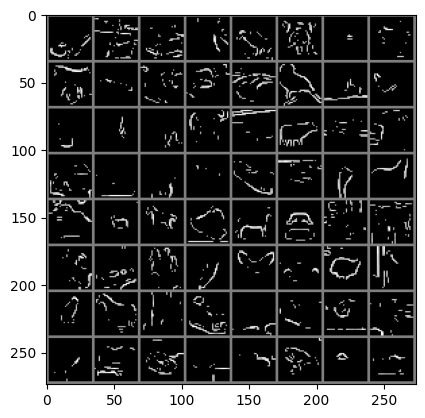

frog  deer  car   dog   frog  dog   deer  frog 


In [6]:
from torchvision.utils import make_grid
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [7]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(DEVICE)
        y = y.to(DEVICE)
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
Epoch: 2 | Batch index: 0 | Batch size: 64


In [8]:
##########################
######### MODEL ##########
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=Bottleneck,
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [9]:
torch.manual_seed(RANDOM_SEED)

model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
#NUM_EPOCHS = 100

def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, val_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


torch.save(model.state_dict(), 'resnet34.pth')

Epoch: 001/100 | Batch 0000/0547 | Cost: 2.7163
Epoch: 001/100 | Batch 0050/0547 | Cost: 3.0322
Epoch: 001/100 | Batch 0100/0547 | Cost: 5.2363
Epoch: 001/100 | Batch 0150/0547 | Cost: 2.9044
Epoch: 001/100 | Batch 0200/0547 | Cost: 3.1373
Epoch: 001/100 | Batch 0250/0547 | Cost: 2.2983
Epoch: 001/100 | Batch 0300/0547 | Cost: 3.1284
Epoch: 001/100 | Batch 0350/0547 | Cost: 2.1483
Epoch: 001/100 | Batch 0400/0547 | Cost: 2.3888
Epoch: 001/100 | Batch 0450/0547 | Cost: 2.2812
Epoch: 001/100 | Batch 0500/0547 | Cost: 2.2201
Epoch: 001/100 | Validation: 21.727%
Time elapsed: 0.73 min
Epoch: 002/100 | Batch 0000/0547 | Cost: 1.9647
Epoch: 002/100 | Batch 0050/0547 | Cost: 2.0610
Epoch: 002/100 | Batch 0100/0547 | Cost: 2.1302
Epoch: 002/100 | Batch 0150/0547 | Cost: 2.0044
Epoch: 002/100 | Batch 0200/0547 | Cost: 2.0385
Epoch: 002/100 | Batch 0250/0547 | Cost: 2.0604
Epoch: 002/100 | Batch 0300/0547 | Cost: 2.1446
Epoch: 002/100 | Batch 0350/0547 | Cost: 1.9564
Epoch: 002/100 | Batch 0400/

## Code Test Space

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn.functional as F
x = torch.randn([1, 256, 3, 3, 3])
sobel = [[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]
depth = x.size()[1]
channels = x.size()[2]
sobel_kernel = torch.tensor(sobel, dtype=torch.float32).unsqueeze(0).expand(depth, 1, channels, 3, 3)
print(sobel_kernel.shape)
#torch.Size([256, 1, 3, 3, 3])
malignacy = F.conv3d(x, sobel_kernel, stride=1, padding=1, groups=x.size(1))
print(malignacy.shape)
#torch.Size([1, 256, 3, 3, 3])

torch.Size([256, 1, 3, 3, 3])
torch.Size([1, 256, 3, 3, 3])


In [ ]:
filters = torch.randn(1, 1, 3, 3)
inputs = torch.randn(128, 1, 128, 128)
F.conv2d(inputs, filters, padding=1).shape

torch.Size([128, 1, 128, 128])

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

img = Image.open("/content/lena_gray_512.tif")

In [ ]:
import numpy as np
img_arr = np.array(img)
import matplotlib.pyplot as plt
img_arr = img_arr.reshape([1, 1, img_arr.shape[0],img_arr.shape[1]])
#plt.imshow(img_arr, cmap='gray')

img_arr_t = torch.from_numpy(img_arr/255.)

In [ ]:
F.conv2d(img_arr_t, filters, padding=1)

RuntimeError: ignored

In [ ]:
img_arr_t.shape

torch.Size([1, 1, 512, 512])

In [ ]:
torch.Tensor([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]]).shape

torch.Size([1, 1, 3, 3])

In [ ]:
img_arr_t

tensor([[[[162, 162, 162,  ..., 170, 155, 128],
          [162, 162, 162,  ..., 170, 155, 128],
          [162, 162, 162,  ..., 170, 155, 128],
          ...,
          [ 43,  43,  50,  ..., 104, 100,  98],
          [ 44,  44,  55,  ..., 104, 105, 108],
          [ 44,  44,  55,  ..., 104, 105, 108]]]], dtype=torch.uint8)

In [ ]:
# Sobel Edge Detection
import cv2

#img_arr = cv2.GaussianBlur(img_arr.reshape([512,512]),(3,3), sigmaX=0, sigmaY=0)

sobelx = cv2.Sobel(src=img_arr, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_arr, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3) # Sobel Edge Detection on the Y axis
#sobelxy = cv2.Sobel(src=img_arr, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3) # Combined X and Y Sobel Edge Detection

# Merge the x and y gradient's power
sobel = np.hypot(sobelx, sobely)

# Normalize between 0 and 255
sobel_ = (sobel / sobel.max()) * 255

# Display Sobel Edge Detection Images
#plt.imshow(sobelx)
#cv2.waitKey(0)

#plt.imshow(sobely)
#cv2.waitKey(0)
#norm = (sobelxy - np.min(sobelxy)) / (np.max(sobelxy) - np.min(sobelxy))
#plt.imshow((norm*255.).astype(np.uint8), cmap='gray')
#cv2.waitKey(0)

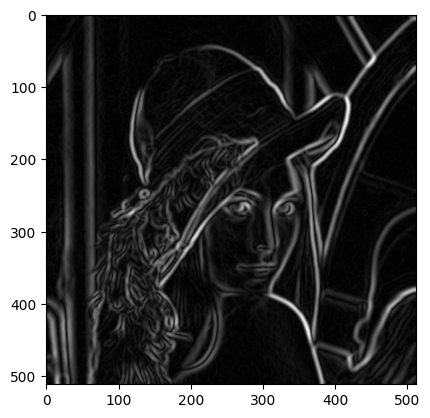

In [ ]:
plt.imshow((sobel_).astype(np.uint8), cmap='gray')